## Thinking process
The database contains three pieces of information which answer these questions:
- who are the users?
- what device are they using?
- how did they play the tutorial?
- how much have they spent? (this data is not available for new users)

The variable `total_spending` lets me know whether the users are likely to spend; and if they are, how much they are going to spend? The in-game packages should not be either too cheap or too expensive; in other words, their prices should attract users. I am going to build a model that predicts the potential score of new users who have just finished the tutorial. The target variable is `total_spending`. The working pipeline is as follow:
1. Gather all three tables into one, then perform train-validation-test split. The split must be done before performing any preprocessing.
2. Perform feature engineering techniques: handle missing values, encode categorical features and extract text data.
3. Construct a function to transform the features. This function is going to be used on any set (train, valid, test) and even data of new users.
4. Build a model to predict the target variable using input features.

In [1]:
import scipy
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

In [4]:
import bayes_opt
from hyperopt import hp, fmin, tpe, Trials

## Read data
After reading 3 files to Pandas dataframe, I save all as parquet zip format so that the next time I read them is much more faster.

In [140]:
db = 'ka_devices.db'
conn = sqlite3.connect(db)
cursor = conn.cursor()

# print out table list
# _ = [print(table[0]) for table in cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]

query = "SELECT * FROM devices"
dfDevice = pd.read_sql_query(query, conn)
conn.close()

dfAction = pd.read_parquet('ka_actions.parquet')
dfUser = pd.read_csv('ka_users.csv')

In [ ]:
dfAction.to_parquet('ka_actions.parquet')
dfUser.to_parquet('ka_users.parquet')

In [5]:
dfAction = pd.read_parquet('ka_actions.parquet')
dfUser = pd.read_parquet('ka_users.parquet')
dfDevice = pd.read_parquet('ka_devices.parquet').drop(columns='index')

## EDA
I perform some simple exploratory data analysis to understand about the data and think about feature engineering approaches.

#### ka_users

- uid_s - unique user identifier
- lang_s - language used on user's device
- geo_s - country level location of the user
- region_s - regional level location of the user
- tz_i - time zone of the user 
- local_time_join_hour - hour of the day when the player first installed 
- local_time_join_dow - day of the week when the player first installed
- total_spend - total in-game spend by the user 

In [141]:
dfUser.head()

,uid_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend
0,0,EN,MY,asia,28800,14,3,0
1,1,ES,MX,americas,-18000,14,1,0
2,2,ZH-CN,CN,asia,28800,2,3,0
3,3,ZH-CN,CN,asia,28800,8,6,0
4,4,EN,IN,asia,19800,19,6,0


In [146]:
dfUser.describe()

,uid_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend
count,2.845931e+06,2.845931e+06,2.845931e+06,2.845931e+06,2.845931e+06
mean,1.422965e+06,1.113074e+04,1.474042e+01,4.207324e+00,1.215356e+00
std,8.215497e+05,1.926607e+04,5.673928e+00,2.305829e+00,1.386070e+01
min,0.000000e+00,-3.960000e+04,0.000000e+00,1.000000e+00,0.000000e+00
25%,7.114825e+05,-1.080000e+04,1.100000e+01,2.000000e+00,0.000000e+00
50%,1.422965e+06,1.980000e+04,1.600000e+01,4.000000e+00,0.000000e+00
75%,2.134448e+06,2.880000e+04,1.900000e+01,6.000000e+00,0.000000e+00
max,2.845930e+06,4.140000e+04,2.300000e+01,7.000000e+00,4.500000e+02


I notice 3 columns: lang_s, geo_s, regions_s may some how relates to the others. For example, the categories in the region_s column is parents of categories in the lang_s column (the relationship between continents and nations).

In [143]:
dfUser[['geo_s', 'region_s']].drop_duplicates().shape

(230, 2)

In [145]:
dfUser.geo_s.unique().shape

(229,)

In [121]:
crt = pd.crosstab(dfUser.region_s, dfUser.geo_s)
chi, pval, dof, _ = scipy.stats.chi2_contingency(crt)
pval

0.0

I have checked the relationship between geo and region, using Chi-square test and group by. It's clear that the lang_s column contains more information than region_s, so I can safely remove it.

In [148]:
dfUser.total_spend.value_counts()

0      2813535
100       1785
50        1751
30        1630
20        1380
        ...   
405          7
410          4
430          3
420          2
450          2
Name: total_spend, Length: 79, dtype: int64

<AxesSubplot:xlabel='total_spend', ylabel='Count'>

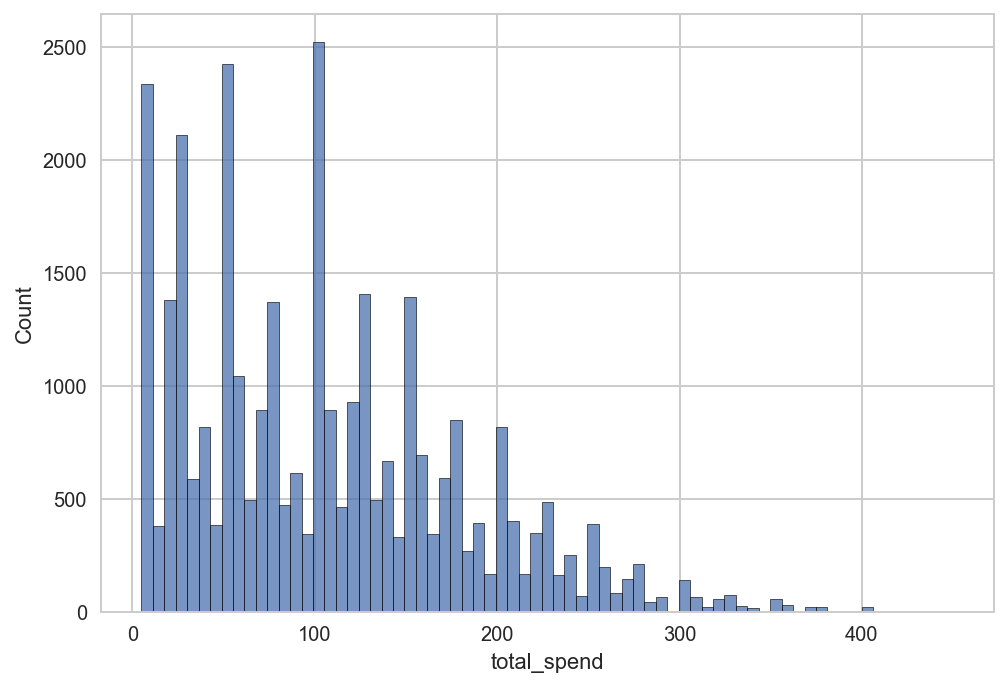

In [162]:
sns.histplot(dfUser.total_spend[dfUser.total_spend>0])

#### ka_devices

- uid_s - unique user identifier
- platform_s - installation platform
- device_mapped_s - common name for device used
- device_manufacturer_s - device manufacturer
- device_mem_i - main memory size for device
- device_gmem_i - graphical memory size for device  
- device_mem_grouping_i - grouping of the device based on memory size
- device_gmem_grouping_i - grouping of the device based on graphical memory size
- device_numcpu_i - number of cores in CPU
- device_height_i - height of the device
- device_gpu_s - chipset of the device
- device_os_s - operating system of the device
- device_model_s - model number of the device

In [149]:
dfDevice.head()

,uid_s,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,device_model_s
0,0,android,asus_x01ad,asus,3575.0,1024.0,3584.0,1024.0,8.0,720.0,adreno (tm) 506,android os 9 / api-28 (ww_phone-201905061022/1...,asus_x01ad
1,1,android,moto g (5),motorola,1867.0,512.0,1920.0,512.0,8.0,1080.0,adreno (tm) 505,android os 8.1.0 / api-27 (opps28.85-13-6/04442),moto g (5)
2,2,android,mi 6,xiaomi,3726.0,1024.0,3776.0,1024.0,8.0,1080.0,adreno (tm) 540,android os 8.0.0 / api-26 (opr1.170623.027/v10...,mi 6
3,3,android,oppo r7splus,oppo,3629.0,1024.0,3648.0,1024.0,8.0,1080.0,adreno (tm) 405,android os 5.1.1 / api-22 (lmy47v/eng.root.201...,oppo r7splus
4,4,android,cph1803,oppo,2816.0,1024.0,2816.0,1024.0,8.0,720.0,adreno (tm) 506,android os 8.1.0 / api-27 (opm1.171019.026/155...,cph1803


In [154]:
dfDevice.describe()

,uid_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i
count,2.845931e+06,2.845930e+06,2.845930e+06,2.845930e+06,2.845930e+06,2.845930e+06,2.845930e+06
mean,1.422965e+06,2.668946e+03,8.180216e+02,2.701934e+03,8.180216e+02,5.814524e+00,8.908536e+02
std,8.215497e+05,2.870858e+03,5.216923e+02,2.871435e+03,5.216923e+02,2.426736e+00,2.548661e+02
min,0.000000e+00,3.410000e+02,1.280000e+02,3.840000e+02,1.280000e+02,1.000000e+00,2.400000e+02
25%,7.114825e+05,1.822000e+03,5.120000e+02,1.856000e+03,5.120000e+02,4.000000e+00,7.200000e+02
50%,1.422965e+06,2.753000e+03,1.024000e+03,2.816000e+03,1.024000e+03,8.000000e+00,8.000000e+02
75%,2.134448e+06,3.595000e+03,1.024000e+03,3.648000e+03,1.024000e+03,8.000000e+00,1.080000e+03
max,2.845930e+06,4.148139e+06,2.621440e+05,4.148160e+06,2.621440e+05,3.200000e+01,2.960000e+03


In this table, device_model and device_mapped have almost no difference. Also, the platform column contains parent categories of device_model, I will remove platform. The device_os column contains alot of information, but I will extract the number of the verion only.

I notice that device_model and device_gpu have unlimited number of categories. So I decide to classify less popular categories to "other" as well as new gpus and models. I choose the threshold to be 99% to re-label less popular categories, meaning only 1% is classified "other". This reduces the information loss.

In [150]:
dfDevice.device_model_s.value_counts()

iphone8,1     55530
iphone7,2     51885
iphone9,3     39602
iphone11,8    34154
oppo a57      30974
              ...  
c66               1
ap-757g           1
a101x             1
p8 max            1
quicktab          1
Name: device_model_s, Length: 19084, dtype: int64

In [151]:
dfDevice.device_mapped_s.value_counts()

iphone8,1                        55530
iphone 6                         51886
iphone 5s                        40989
iphone9,3                        39602
iphone11,8                       34154
                                 ...  
5e2 lte                              1
lg-d806                              1
radio shack elite 5r                 1
sm-a505x                             1
aero j0101     j0101hc5amc1xx        1
Name: device_mapped_s, Length: 18977, dtype: int64

In [152]:
dfDevice.device_manufacturer_s.value_counts()

apple           664025
samsung         574271
oppo            437369
huawei          356579
xiaomi          166686
                 ...  
km                   1
mingzhuo             1
jivi_mobiles         1
sp                   1
x-tigi_s1553         1
Name: device_manufacturer_s, Length: 3029, dtype: int64

In [153]:
dfDevice.device_gpu_s.value_counts()

adreno (tm) 506                                                           210153
mali-t720                                                                 192953
mali-t830                                                                 192288
mali-400 mp                                                               151918
adreno (tm) 505                                                           141718
                                                                           ...  
gallium 0.4 on amd palm (drm 2.48.0 / 4.9.24-android-x86+, llvm 3.5.0)         1
angle (amd radeon hd 6670 direct3d11 vs_5_0 ps_5_0)                            1
mumu gl (amd radeon r5 235 direct3d11 vs_5_0 ps_5_0)                           1
mumu gl (nvidia geforce gtx 950m       direct3d11 vs_5_0 ps_5_0)               1
angle (amd radeon hd 7560d direct3d11 vs_5_0 ps_5_0)                           1
Name: device_gpu_s, Length: 566, dtype: int64

#### ka_actions

- uid_s - unique user identifier
- logins - number of logins since install
- game_stats_tutorial_complete - whether user completed tutorial
- game_stats_tutorial_complete_time - time (microseconds) to complete game tutorial
- game_stats_xp - experience points accumulated by first time interval from install
- game_stats_xp1 - experience points accumulated by second time interval from install
- game_stats_xp2 - experience points accumulated by third time interval from install
- game_stats_xp3 - experience points accumulated by fourth time interval from install
- redeemer_actions - number of 'redeemer' actions since install (Note: 'redeemer' is a type of in-game action)
- scribe_actions - number of 'scribe' actions since install (Note: 'scribe' is a type of in-game action)

In [155]:
dfAction.head()

,uid_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
0,0,7.0,1.0,4.700000e+08,1693.0,592.0,0.0,429.0,446.0,364.0
1,1,2.0,1.0,6.120000e+08,197.0,197.0,0.0,0.0,60.0,125.0
2,2,2.0,1.0,3.900000e+08,313.0,313.0,0.0,0.0,89.0,129.0
3,3,3.0,1.0,6.610000e+08,1319.0,1319.0,0.0,0.0,275.0,200.0
4,4,4.0,1.0,3.147000e+09,148.0,148.0,0.0,0.0,58.0,138.0


In [156]:
dfAction.describe()

,uid_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
count,2.845931e+06,2.845894e+06,1.756997e+06,1.751748e+06,2.083043e+06,2.083043e+06,2.083043e+06,2.083043e+06,2.835649e+06,2.845930e+06
mean,1.422965e+06,2.961407e+00,9.970125e-01,1.750700e+09,8.966738e+02,4.481845e+02,1.290063e+02,7.907115e+01,1.312056e+02,1.332405e+02
std,8.215497e+05,2.254042e+00,5.457619e-02,3.818346e+09,7.353939e+03,6.952799e+03,5.728121e+02,5.018453e+02,2.295778e+02,9.406660e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,2.280000e+08,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00
25%,7.114825e+05,2.000000e+00,1.000000e+00,5.080000e+08,9.000000e+01,8.000000e+01,0.000000e+00,0.000000e+00,2.500000e+01,7.000000e+01
50%,1.422965e+06,2.000000e+00,1.000000e+00,6.370000e+08,3.130000e+02,3.090000e+02,0.000000e+00,0.000000e+00,5.300000e+01,1.290000e+02
75%,2.134448e+06,3.000000e+00,1.000000e+00,9.430000e+08,7.860000e+02,5.950000e+02,0.000000e+00,0.000000e+00,1.340000e+02,1.670000e+02
max,2.845930e+06,8.790000e+02,1.000000e+00,2.880000e+10,1.000023e+07,1.000023e+07,4.604800e+04,4.697300e+04,9.078000e+03,1.072000e+04


In [160]:
dfAction.corr()

,uid_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
uid_s,1.000000,-0.027005,-0.010209,0.002955,-0.002488,-0.001827,-0.006516,-0.001061,-0.004261,-0.004763
logins,-0.027005,1.000000,0.013351,0.162022,0.066331,0.006486,0.136865,0.145196,0.248741,0.451776
game_stats_tutorial_complete,-0.010209,0.013351,1.000000,NaN,-0.007126,-0.011223,0.012847,0.009077,0.028180,0.041772
game_stats_tutorial_complete_time,0.002955,0.162022,NaN,1.000000,-0.048646,-0.222293,-0.042318,-0.011304,-0.066265,0.017229
game_stats_xp,-0.002488,0.066331,-0.007126,-0.048646,1.000000,0.954659,0.236963,0.240898,0.305165,0.231805
game_stats_xp1,-0.001827,0.006486,-0.011223,-0.222293,0.954659,1.000000,0.040261,0.023485,0.058600,0.052169
game_stats_xp2,-0.006516,0.136865,0.012847,-0.042318,0.236963,0.040261,1.000000,0.565179,0.691370,0.542336
game_stats_xp3,-0.001061,0.145196,0.009077,-0.011304,0.240898,0.023485,0.565179,1.000000,0.636875,0.465396
redeemer_actions,-0.004261,0.248741,0.028180,-0.066265,0.305165,0.058600,0.691370,0.636875,1.000000,0.811995
scribe_actions,-0.004763,0.451776,0.041772,0.017229,0.231805,0.052169,0.542336,0.465396,0.811995,1.000000


In [157]:
quantiles = [0, 0.05, 0.1, 0.2, 0.35, 0.5, 0.65, 0.8, 0.9, 0.95, 1]
dfAction.redeemer_actions.quantile(quantiles)

0.00       1.0
0.05      12.0
0.10      12.0
0.20      13.0
0.35      36.0
0.50      53.0
0.65      92.0
0.80     169.0
0.90     306.0
0.95     521.0
1.00    9078.0
Name: redeemer_actions, dtype: float64

In [159]:
quantiles = [0, 0.05, 0.1, 0.2, 0.35, 0.5, 0.65, 0.8, 0.9, 0.95, 1]
dfAction.scribe_actions.quantile(quantiles)

0.00        3.0
0.05        9.0
0.10       18.0
0.20       50.0
0.35      105.0
0.50      129.0
0.65      148.0
0.80      183.0
0.90      245.0
0.95      313.0
1.00    10720.0
Name: scribe_actions, dtype: float64

redeemer_actions and scribe_actions seems heavily right skewed. Log transform may be a considerable strategy.

In [158]:
dfAction.game_stats_tutorial_complete.value_counts()

1.0    1751748
0.0       5249
Name: game_stats_tutorial_complete, dtype: int64

## Train, valid, test split

In [6]:
dfGame = dfAction.merge(dfUser, on='uid_s', how='left')
dfGame = dfGame.merge(dfDevice, on='uid_s', how='left')
dfGame.isna().mean().map('{:.4%}'.format)

uid_s                                 0.0000%
logins                                0.0013%
game_stats_tutorial_complete         38.2628%
game_stats_tutorial_complete_time    38.4473%
game_stats_xp                        26.8063%
game_stats_xp1                       26.8063%
game_stats_xp2                       26.8063%
game_stats_xp3                       26.8063%
redeemer_actions                      0.3613%
scribe_actions                        0.0000%
lang_s                                0.0000%
geo_s                                 0.0044%
region_s                              0.0000%
tz_i                                  0.0000%
local_time_join_hour                  0.0000%
local_time_join_dow                   0.0000%
total_spend                           0.0000%
platform_s                            0.0000%
device_mapped_s                       0.0002%
device_manufacturer_s                 0.0002%
device_mem_i                          0.0000%
device_gmem_i                     

In [7]:
# spending information, which is not available for new users
target = ['total_spend']

xRaw = dfGame.drop(columns=target + ['uid_s'])
yRaw = dfGame[target]

seed = 7
xRawTrain, xRawTest, yRawTrain, yRawTest = train_test_split(xRaw, yRaw, test_size=1/10, random_state=seed)
xRawTrain, xRawValid, yRawTrain, yRawValid = train_test_split(xRawTrain, yRawTrain, test_size=1/9, random_state=seed)

## Preprocessing

In [8]:
threshold = 0.99

countCumGpu = dfDevice.device_gpu_s.value_counts().cumsum()
listMajorGpu = countCumGpu[countCumGpu < dfDevice.shape[0] * threshold].index.values.reshape(-1,1)
encoderGpu = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoderGpu = encoderGpu.fit(listMajorGpu)

countCumModel = dfDevice.device_model_s.value_counts().cumsum()
listMajorModel = countCumModel[countCumModel < dfDevice.shape[0] * threshold].index.values.reshape(-1,1)
encoderModel = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoderModel = encoderModel.fit(listMajorModel)

encoderManufacturer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoderManufacturer = encoderManufacturer.fit(dfDevice.device_manufacturer_s.unique().reshape(-1,1))

encoderLanguage = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoderLanguage = encoderLanguage.fit(dfUser.lang_s.unique().reshape(-1,1))

encoderGeo = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoderGeo = encoderGeo.fit(dfUser.geo_s.unique().reshape(-1,1))

In [9]:
def transform_features(xRaw:pd.DataFrame) -> np.array:
    x = xRaw.copy()
    
    # action features
    colsFillZero = ['game_stats_xp', 'game_stats_xp1', 'game_stats_xp2', 'game_stats_xp3']
    colsFillOne = ['game_stats_tutorial_complete']
    x[colsFillZero] = x[colsFillZero].fillna(0)
    x[colsFillOne] = x[colsFillOne].fillna(1)
    x['game_stats_tutorial_complete_time'] = x['game_stats_tutorial_complete_time'] / 1e6
    
    # device features
    x['device_os_s'] = x.device_os_s.str.split(' / ').str[0]
    x['os_version_s'] = x.device_os_s.str.split(' ').str[-1]
    x['os_version_s'] = x.os_version_s.str.extract(r'(\d+)').astype(float)
    x['device_os_s'] = x.device_os_s.str.split(' ').str[0]
    x = x.drop(columns=['platform_s', 'device_mapped_s', 'device_os_s'])
    x['device_gpu_s'] = encoderGpu.transform(x[['device_gpu_s']].values)
    x['device_model_s'] = encoderModel.transform(x[['device_model_s']].values)
    x['device_manufacturer_s'] = encoderManufacturer.transform(x[['device_manufacturer_s']].values)
    
    # user features
    x['tz_i'] = x['tz_i'] / 3600
    x = x.drop(columns=['region_s'])
    x['lang_s'] = encoderLanguage.transform(x[['lang_s']].values)
    x['geo_s'] = encoderGeo.transform(x[['geo_s']].values)
    
    # pandas to numpy
    x = x

    return x

def transform_label(yRaw:pd.DataFrame) -> np.array:
    y = yRaw.copy()
    
    # pandas to numpy
    y = y.values.flatten()
    
    return y

In [10]:
xTrain, xValid, xTest = [transform_features(i) for i in [xRawTrain, xRawValid, xRawTest]]
yTrain, yValid, yTest = [transform_label(i) for i in [yRawTrain, yRawValid, yRawTest]]

In [11]:
listCategoricalFeature = [
    'lang_s',
    'geo_s',
    'local_time_join_dow',
    'device_manufacturer_s',
    'device_gpu_s',
    'device_model_s',
]

## Model approach 1
Predict total_spend using LGBMRegressor. Since time and resources are limited I do not use grid search or randomized search, but change hyperparams one by one, thanks to my deep understanding about the alogrithm. The code here only shows the best model. Here is how I tune the model:
- start with default hyperparams, the model is underfit (R2 is about 0.05)
- specify categorical features, since LightGBM has an unique mechanic handling integer-encoded categorical features
- sset the early stopping rounds to be 10% of n_estimators
- increase the n_estimator and lower the learning_rate. I do this very slowly.
- keep increasing n_estimator but now retain the learning_rate, and increase max_bin and num_leaves

Since the performance on the valid set is not very good, I move to another solution.

In [161]:
listCategoricalFeature = [
    'lang_s',
    'geo_s',
    'local_time_join_dow',
    'device_manufacturer_s',
    'device_gpu_s',
    'device_model_s',
]
dataTrain = lgb.Dataset(xTrain, yTrain, categorical_feature=listCategoricalFeature)
dataValid = lgb.Dataset(xValid, yValid, categorical_feature=listCategoricalFeature, reference=dataTrain)

nTree = 5000
params = {
    'objective': 'regression',
    'n_estimators': nTree,
    'learning_rate': 0.03,
    'max_bin': 2**10,
    'num_leaves': 2**6,
    'verbose': -1,
    'force_col_wise': True,
    'metric': 'mse',
}

model0 = lgb.train(
    params=params,
    train_set=dataTrain,
    valid_sets=[dataValid],
    callbacks=[lgb.early_stopping(0.1 * nTree)],
)

Training until validation scores don't improve for 500.0 rounds
Early stopping, best iteration is:
[725]	valid_0's l2: 175.735


In [166]:
yTrainPred0 = model0.predict(xTrain, num_iteration=model0.best_iteration)
r2_score(yTrain, yTrainPred0)

0.19974283555154138

In [180]:
yValidPred0 = model0.predict(xValid, num_iteration=model0.best_iteration)
r2_score(yValid, yValidPred0)

0.062174442619160386

In [181]:
yTestPred0 = model0.predict(xTest, num_iteration=model0.best_iteration)
r2_score(yTest, yTestPred0)

0.0559916978792141

## Model approach 2
This time, I train 2 models:
- a classifier to determine if the users spend. The hyperparams tuning is same as above, but this time the model is a little overfit (aucTrain=0.96, aucValid=0.88). I use some regularization (l1, l2) and use bagging to make two values closer.
- a regressor to predict the amount spend on the positive part only. Unfortunately, this model is terrible (R2~0), same as using averge as the prediction for all observations.

In [25]:
yTrain1 = yTrain.copy()
yTrain1[yTrain1 > 0] = 1

yValid1 = yValid.copy()
yValid1[yValid1 > 0] = 1

yTest1 = yTest.copy()
yTest1[yTest1 > 0] = 1

In [169]:
dataTrain1 = lgb.Dataset(xTrain, yTrain1, categorical_feature=listCategoricalFeature)
dataValid1 = lgb.Dataset(xValid, yValid1, categorical_feature=listCategoricalFeature, reference=dataTrain)

nTree = 5000
params = {
    'objective': 'binary',
    'n_estimators': nTree,
    'learning_rate': 0.03,
    'max_bin': 2**9,
    'num_leaves': 2**5,
    'scale_pos_weight': 2,
    'lambda_l1': 1,
    'lambda_l2': 0.1,
    'bagging_fraction': 0.5,
    'feature_fraction': 0.5,
    'verbose': -1,
    'force_col_wise': True,
    'metric': 'cross_entropy',
}

model1 = lgb.train(
    params=params,
    train_set=dataTrain1,
    valid_sets=[dataValid1],
    callbacks=[lgb.early_stopping(0.1 * nTree)],
)

Training until validation scores don't improve for 500.0 rounds
Early stopping, best iteration is:
[1487]	valid_0's cross_entropy: 0.0474842


In [175]:
yTrainPred1 = model1.predict(xTrain, num_iteration=model1.best_iteration)
roc_auc_score(yTrain1, yTrainPred1)

0.9539432414694646

In [176]:
yValidPred1 = model1.predict(xValid, num_iteration=model1.best_iteration)
roc_auc_score(yValid1, yValidPred1)

0.8998312187062972

In [179]:
yTestPred1 = model1.predict(xTest, num_iteration=model1.best_iteration)
roc_auc_score(yTest1, yTestPred1)

0.8997846047696433

## Bayesian Optimization

In [33]:
dataTrain1 = lgb.Dataset(xTrain, yTrain1, categorical_feature=listCategoricalFeature)
dataValid1 = lgb.Dataset(xValid, yValid1, categorical_feature=listCategoricalFeature, reference=dataTrain1)

In [40]:
trials = Trials()

nTree = 1000
space = {
    'n_estimators': nTree,
    'learning_rate': 0.03,
    'max_bin': 2**9,
    'num_leaves': 2**5,
    'scale_pos_weight': 2,
    'lambda_l1': hp.choice('lambda_l1', np.logspace(-3, 1, 5)),
    'lambda_l2': hp.choice('lambda_l2', np.logspace(-3, 1, 5)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.2, 0.8),
    'feature_fraction': hp.uniform('feature_fraction', 0.2, 0.8),
    'verbose': -1,
    'force_col_wise': True,
    'metric': 'cross_entropy',
}

def objective(params):
    clf = LGBMClassifier(**params)
    clf.fit(
        xTrain, yTrain1,
        eval_set=[(xValid, yValid1)],
        eval_names=['Valid'],
        eval_metric=['binary_logloss', 'auc'],
        callbacks=[
            lgb.early_stopping(20, first_metric_only=True),
            lgb.log_evaluation(period=0),
        ],
    )
    yValidPred1 = clf.predict(xValid)
    return -1 * roc_auc_score(yValid1, yValidPred1)

In [41]:
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20
)
best

Training until validation scores don't improve for 20 rounds                                                           
Early stopping, best iteration is:                                                                                     
[775]	Valid's binary_logloss: 0.0470206	Valid's auc: 0.907249	Valid's cross_entropy: 0.0470206
Evaluated only: binary_logloss                                                                                         
[LightGBM] [Warning] feature_fraction is set=0.45010189472772666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45010189472772666
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1                 
[LightGBM] [Warning] bagging_fraction is set=0.5455417542400245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5455417542400245
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0                
Tr

{'bagging_fraction': 0.45634717476063075,
 'feature_fraction': 0.6194461542022387,
 'lambda_l1': 3,
 'lambda_l2': 1}

In [121]:
maskTrain = yTrain > 0
maskValid = yValid > 0

yTrain2 = yTrain[maskTrain]
xTrain2 = xTrain[maskTrain]

yValid2 = yValid[maskValid]
xValid2 = xValid[maskValid]

In [131]:
dataTrain2 = lgb.Dataset(xTrain2, yTrain2, categorical_feature=listCategoricalFeature)
dataValid2 = lgb.Dataset(xValid2, yValid2, categorical_feature=listCategoricalFeature, reference=dataTrain2)

nTree = 10000
params = {
    'objective': 'regression',
    'n_estimators': nTree,
    'learning_rate': 0.01,
    'max_bin': 2**10,
    'num_leaves': 2**6,
    'verbose': -1,
    'force_col_wise': True,
    'metric': 'mse',
}

model2 = lgb.train(
    params=params,
    train_set=dataTrain2,
    valid_sets=[dataValid2],
    callbacks=[lgb.early_stopping(0.1 * nTree)],
)

Training until validation scores don't improve for 1000.0 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 5368.22


In [132]:
yTrainPred2 = model2.predict(xTrain2, num_iteration=model.best_iteration)
r2_score(yTrain2, yTrainPred2)

0.000707557689440419

In [133]:
yValidPred2 = model2.predict(xValid2, num_iteration=model.best_iteration)
r2_score(yValid2, yValidPred2)

-0.00014354173370789702

Since the model2 cannot be used, I will stack model0 and model1 as the prediction for the spending amount.

In [182]:
model0.save_model('model0.txt')

In [183]:
model1.save_model('model1.txt')

## Conclusion
- model1 (classifier) is the model I use to predict if a user is going to spend. It achieved a pretty good auc at 0.8997 on the test set.
- model0 (regressor) is for predicting the amount an user is going to spend. It achieved a r2 score of 0.0560, and is going to need further  feature engineering. In the case I must give a score reprensenting prices, the probability from model1 is an acceptable alternative.